In [1]:
from utils import u_time as ut
from eod import read_eod as re
import salem
import datetime as dt
import numpy as np
from scipy.ndimage.measurements import label 
import pyproj
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from wavelet import util
import cleo
from skimage.feature import match_template
import pickle as pkl
from skimage.measure import compare_ssim
from scipy.stats.stats import pearsonr
pylab.rcParams['figure.figsize'] = 20., 12.
%matplotlib inline

2009-09-19 15:41:00
2009-09-19 15:45:00


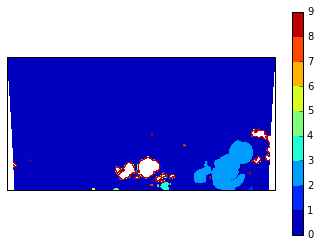

In [2]:
trmm_folder='/users/global/cornkle/data/OBS/TRMM/trmm_swaths_WA'
msg_folder='/users/global/cornkle/data/OBS/meteosat_SA15'
# make a salem grid
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
_y = 2009
_m = 9
_d = 19
_h = 15
_mi = 41

m=re.msg(msg_folder)
t=re.trmm(trmm_folder, yrange=range(2009, 2010), area=[-10, 10, 10, 20]) 

arr=np.array([15,30,45,60, 0])
dm = arr - _mi
ind=(np.abs(dm)).argmin()
       
# set zero shift time for msg
date=dt.datetime(_y, _m, _d, _h, _mi)
print(date)
dt0=dm[ind] 
ndate = date + dt.timedelta(minutes=int(dt0))   
print(ndate)
td=t.getDData(date.year, date.month, date.day, date.hour, date.minute, cut=[9,21])
              
d=m.getData(y=ndate.year, m=ndate.month, d=ndate.day, h=ndate.hour, mi=ndate.minute, llbox=[td['lon'].min(), td['lon'].max(), td['lat'].min(), td['lat'].max() ])
d1 = d['t']
lon1=d['lon']
lat1=d['lat']
d1[d1>-20]=0
labels, numL = label(d1)
u , inv = np.unique(labels, return_inverse=True)
n = np.bincount(inv)

ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon1, lat1, labels, levels=np.arange(0,10,1), transform=ccrs.PlateCarree())
ax.coastlines()
cbar=plt.colorbar()

In [3]:
inds=np.where(labels==3)
# cut a box for every single blob from msg - get min max lat lon of the blob
latmax, latmin = lat1[inds].max() , lat1[inds].min()
lonmax, lonmin = lon1[inds].max() , lon1[inds].min()
td = t.getDData(date.year, date.month, date.day, date.hour, date.minute, cut=[latmin-0.2, latmax+0.2])

dt0=dm[ind] 
ndate = date + dt.timedelta(minutes=int(dt0) )                
print('Date1', ndate)                              
ml0=m.getData(y=ndate.year, m=ndate.month, d=ndate.day, h=ndate.hour, mi=ndate.minute, llbox=[lonmin-0.3, lonmax+0.3, latmin-0.25, latmax+0.25])        
             
              
dt1=dm[ind]-15
ndate = date + dt.timedelta(minutes=int(dt1))       
print('Date2', ndate)  
ml1=m.getData(y=ndate.year, m=ndate.month, d=ndate.day, h=ndate.hour, mi=ndate.minute, llbox=[lonmin-0.3, lonmax+0.3, latmin-0.25, latmax+0.25])               
            
              
dt2=dm[ind]-30      
ndate = date + dt.timedelta(minutes=int(dt2)  )     
print('Date3', ndate)  
ml2=m.getData(y=ndate.year, m=ndate.month, d=ndate.day, h=ndate.hour, mi=ndate.minute, llbox=[lonmin-0.3, lonmax+0.3, latmin-0.25, latmax+0.25])     

dt3=dm[ind]-45      
ndate = date + dt.timedelta(minutes=int(dt3)  )  
print('Date4', ndate)  
ml3=m.getData(y=ndate.year, m=ndate.month, d=ndate.day, h=ndate.hour, mi=ndate.minute, llbox=[lonmin-0.3, lonmax+0.3, latmin-0.25, latmax+0.25])             

Date1 2009-09-19 15:45:00
Date2 2009-09-19 15:30:00
Date3 2009-09-19 15:15:00
Date4 2009-09-19 15:00:00


In [5]:
x, y = pyproj.transform(salem.wgs84, proj, ml0['lon'], ml0['lat'])
xmax, xmin = np.max(x), np.min(x)
ymax, ymin = np.max(y), np.min(y)
dx = 5000
nx, r = divmod(xmax - xmin, dx)
ny, r = divmod(ymax - ymin, dx)
grid = salem.Grid(nxny=(nx, ny), dxdy=(dx, dx), ll_corner=(xmin, ymin), proj=proj)            
xi, yi = grid.ij_coordinates
lon, lat = grid.ll_coordinates
xm, ym = grid.transform( ml0['lon'].flatten(), ml0['lat'].flatten(), crs=salem.wgs84)
xt, yt = grid.transform(td['lon'].flatten(), td['lat'].flatten(), crs=salem.wgs84)
mpoints = np.array((ym, xm)).T
tpoints = np.array((yt, xt)).T
inter = np.array((np.ravel(yi), np.ravel(xi))).T
 
outm = griddata(mpoints, ml0['t'].flatten(), inter, method='linear')
outm = outm.reshape((grid.ny, grid.nx))
outt = griddata(tpoints, td['p'].flatten(), inter, method='linear')
outt = outt.reshape((grid.ny, grid.nx)) 

In [6]:
# zero lag
outt=outt[1:-1, 4:-4]
outm=outm[1:-1, 4:-4]
outt[np.isnan(outt)]=-10**-5
outm[np.isnan(outm)]=30     

                                          
# lag -1      
outm1 = griddata(mpoints, ml1['t'].flatten(), inter, method='linear')
outm1 = outm1.reshape((grid.ny, grid.nx))
outm1=outm1[1:-1, 4:-4]
outm1[np.isnan(outm1)]=30     

                        
# lag -2
outm2 = griddata(mpoints, ml2['t'].flatten(), inter, method='linear')
outm2 = outm2.reshape((grid.ny, grid.nx))   
outm2=outm2[1:-1, 4:-4]
outm2[np.isnan(outm2)]=30                                 

# lag -3
outm3 = griddata(mpoints, ml3['t'].flatten(), inter, method='linear')
outm3 = outm3.reshape((grid.ny, grid.nx))   
outm3=outm3[1:-1, 4:-4]
outm3[np.isnan(outm3)]=30                                 

llon = lon[1:-1, 4:-4]
llat = lat[1:-1, 4:-4]

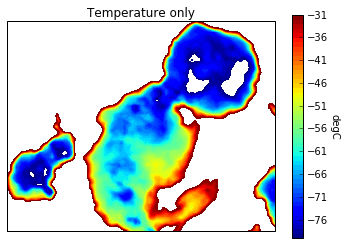

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(llon, llat ,outm,levels=np.arange(-80,-30,1), transform=ccrs.PlateCarree(), cmap='jet')
cbar=plt.colorbar()
cbar.set_label('degC', rotation=270, labelpad=+11)
plt.title('Temperature only')
#plt.savefig('/users/global/cornkle/T_original.pdf')

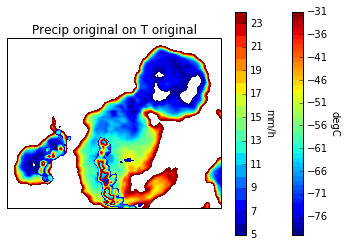

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(llon, llat ,outm,levels=np.arange(-80,-30,1), transform=ccrs.PlateCarree(), cmap='jet')
cbar=plt.colorbar()
cbar.set_label('degC', rotation=270, labelpad=+11)
plt.contourf(llon, llat, outt,levels=np.arange(5,25,1), transform=ccrs.PlateCarree())
cbar=plt.colorbar()
cbar.set_label('mm/h', rotation=270, labelpad=+11)
plt.contour(llon, llat, outt,levels=np.arange(100,110,1), transform=ccrs.PlateCarree())
plt.title('Precip original on T original')
plt.savefig('/users/global/cornkle/grpm/PonT_original.pdf')
ax.coastlines()

In [119]:
pearsonr(outt[outt>2].flatten(), outm[outt>2].flatten())   

(-0.28023276629442995, 8.7662379289887844e-11)

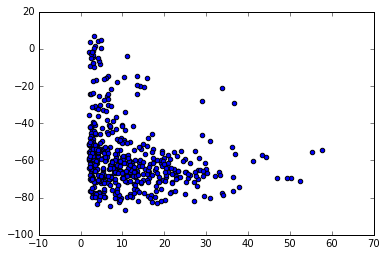

In [120]:
plt.scatter(outt[outt>2], outm1[outt>2])

In [16]:
thing=match_template(outm, outt[10:-10, 10:-10])
print(min(thing.flatten()))

-0.214481


In [12]:
y,x = np.unravel_index(np.argmax(thing), thing.shape)

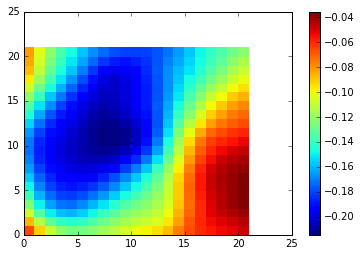

In [13]:
plt.pcolormesh(thing)
plt.colorbar()
plt.plot(10,10, 'bo')

In [134]:
compare_ssim(outt, outm3)

0.00067964763037011398